In [366]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
import ternary
import warnings
import random

%matplotlib inline
warnings.filterwarnings('ignore')

# Conclusions from this notebook


## Herbivores

**Intrinsic growth rate of herbivores:** $s1-3 = 0.18 (G), 0.13 (B), 0.5 (S) $

**Herbivore emigration rates:** $e1-3 = 0 $

**Herbivore immigration rates:** $m1-3 = 0 $


## Herbivore-benthos Mediators

**Herbivory rate per browser (B) on macroalgae:** $g1 = (0.01)g2 = (0.01)g3 yr^{-1}$ ***(Fung et al., 2011)***

**Herbivory rate per grazers (G) on turf:** $g2 = 5-15 yr^{-1}$ ***(Fung et al., 2011)***

**Herbivory rate per scapers (S) on turf:** $g3 = 5-15 yr^{-1}$ ***(Fung et al., 2011)***

**Palatability of macroalgae/algae"** $n = 0.0 - 1.0$ ***(van de Leemput et al., 2016)***

**Dependence of herbivores on coral for carrying capacity:** $sigma = 0.0 - 1.0$ ***(van de Leemput et al., 2016)***


## Benthos

**NET Coral Growth:** $r =  0.0–0.18 yr^{-1}$  ***(Fung et al., 2011)***

**NET Growth rate of macroalgae onto free space:** $gamma = 0.0–1.18 yr^{-1}$ Used values from ***Fung et al., 2011*** but formulation from ***Cook et al., 2023***

**Growth Rate of Turf onto Free Space** $beta = 2–20 yr^{-1}$ ***(Fung et al., 2011)***

**Growth rate of corals onto turf relative to the rate onto free space:** $alpha1 = 0.0-1.0$ ***(Fung et al., 2011)***

**Growth rate of macroalgae onto turf relative to the rate onto free space** $alpha2 = 0–0.9$ ***(Fung et al., 2011)***

**Rate of macroalgae overgrowth onto coral relative to the rate onto free space** $alpha3 = 0–0.9$ ***(Fung et al., 2011)***

# Defining ODE and Parameters

In [367]:
def dNdt(t, N, r, gamma, beta, alpha1, alpha2, alpha3, g1, n, s1, e1, theta1, d1):
    
    C,M,T,B = N
    
    dC = (r*C*(1-C-M-T) + alpha1*r*C*T - alpha3*gamma*C*M)*dt
    dM = (gamma*M*(1-C-M-T) + alpha2*gamma*T*M + alpha3*gamma*C*M - p2*M)*dt #(g1*M*B/((g1*n*M)+1))
    dT = (beta*T*(1-C-M-T) - alpha1*r*C*T - alpha2*gamma*T*M)*dt #- g2*T*G/(b2+T) - g3*T*S/(b3+T)
    dB = ((s1*B*(1-(B/C))) - e1*B - d1*B + theta1*B)*dt
    #dG = s2*G*(1-G/C) - e2*G - d2*G + theta2
    #dS = s3*S*(1-S/C) - e3*S - d3*S + theta3

    return dC, dM, dT, dB #, dG, dS

In [368]:
dt = 1
NUMSTEPS = 10000
NUMYEARS = int(NUMSTEPS/dt)
time_points = np.linspace(0, NUMYEARS, NUMSTEPS+1)

r = (0.0 + 0.18)/2 #coral growth
gamma = (0.0 + 1.18)/2 #macro algae growth rate over free space
beta = (2 + 20)/2 #turf growth rate onto free space
alpha1 = 1.0/2 #growth rate of corals onto turf relative to the rate onto free space
alpha2 = 0.9/2 #growth rate of macroalgae onto turf relative to the rate onto free space
alpha3 = 0.9/2 #rate of macroalgal overgrowth onto coral relative to the rate onto free space
p2 = (0 + 1.1)/2 #macroalgal death rate (based on Cook et al., 2023)

g1 = 0.0
n = 0.0

s1 = 0.0
e1 = 0.0
theta1 = 0.0
d1 = 0.0

C0 = 0.99
M0 = 0.005
T0 = 0.005

B0 = 0.0

In [369]:
par_step = 15

r_value = np.linspace(0.0, 0.18, par_step)
r_value = np.round(r_value,4)

gamma_value = np.linspace(0.0, 1.18, par_step)
gamma_value = np.round(gamma_value,4)

beta_value = np.linspace(2, 20, par_step)
beta_value = np.round(beta_value,4)

alpha1_value = np.linspace(0, 1.0, par_step)
alpha1_value = np.round(alpha1_value,4)

alpha2_value = np.linspace(0, 0.9, par_step)
alpha2_value = np.round(alpha2_value,4)

alpha3_value = np.linspace(0, 0.9, par_step)
alpha3_value = np.round(alpha3_value,4)

## Defining parcross functions (for each, change function title and placement of p1/p2)

In [370]:
# r x all ---------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------

# r x gamma
def parcross_r_gamma(p1_val, p2_val):
    
    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0, B0], method = 'RK45', 
                                args = (p1, 
                                        p2, 
                                        beta, 
                                        alpha1, 
                                        alpha2, 
                                        alpha3, g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)

# r x beta
def parcross_r_beta(p1_val, p2_val):

    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0, B0], method = 'RK45', 
                                args = (p1, 
                                        gamma, 
                                        p2, 
                                        alpha1, 
                                        alpha2, 
                                        alpha3, g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)

# r x alpha1
def parcross_r_a1(p1_val, p2_val):
    
    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0, B0], method = 'RK45', 
                                args = (p1, 
                                        gamma, 
                                        beta, 
                                        p2, 
                                        alpha2, 
                                        alpha3, g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)

# r x alpha2
def parcross_r_a2(p1_val, p2_val):

    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0, B0,], method = 'RK45', 
                                args = (p1, 
                                        gamma, 
                                        beta, 
                                        alpha1, 
                                        p2, 
                                        alpha3, g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)

# r x alpha3
def parcross_r_a3(p1_val, p2_val):
    
    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0, B0], method = 'RK45', 
                                args = (p1, 
                                        gamma, 
                                        beta, 
                                        alpha1, 
                                        alpha2, 
                                        p2, g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)

# gamma x all ---------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------

# gamma x beta
def parcross_gamma_beta(p1_val, p2_val):

    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0, B0], method = 'RK45', 
                                args = (r, 
                                        p1, 
                                        p2, 
                                        alpha1, 
                                        alpha2, 
                                        alpha3, g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)

# gamma x alpha1
def parcross_gamma_a1(p1_val, p2_val):
    
    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0, B0], method = 'RK45', 
                                args = (r, 
                                        p1, 
                                        beta, 
                                        p2, 
                                        alpha2, 
                                        alpha3, g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)

# gamma x alpha2
def parcross_gamma_a2(p1_val, p2_val):

    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0, B0], method = 'RK45', 
                                args = (r, 
                                        p1, 
                                        beta, 
                                        alpha1, 
                                        p2, 
                                        alpha3, g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)

# gamma x alpha3
def parcross_gamma_a3(p1_val, p2_val):

    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0, B0], method = 'RK45', 
                                args = (r, 
                                        p1, 
                                        beta, 
                                        alpha1, 
                                        alpha2, 
                                        p2, g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)

# beta x all ---------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------

# beta x alpha1
def parcross_beta_a1(p1_val, p2_val):

    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0, B0], method = 'RK45', 
                                args = (r, 
                                        gamma, 
                                        p1, 
                                        p2, 
                                        alpha2, 
                                        alpha3, g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)

# beta x alpha2
def parcross_beta_a2(p1_val, p2_val):
    
    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0, B0], method = 'RK45', 
                                args = (r, 
                                        gamma, 
                                        p1, 
                                        alpha1, 
                                        p2, 
                                        alpha3, g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)

# beta x alpha3
def parcross_beta_a3(p1_val, p2_val):

    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0, B0], method = 'RK45', 
                                args = (r, 
                                        gamma, 
                                        p1, 
                                        alpha1, 
                                        alpha2, 
                                        p2, g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)

# alpha1 x all ---------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------

# alpha1 x alpha2
def parcross_a1_a2(p1_val, p2_val):

    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0, B0], method = 'RK45', 
                                args = (r, 
                                        gamma, 
                                        beta, 
                                        p1, 
                                        p2, 
                                        alpha3, g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)

# alpha1 x alpha3
def parcross_a1_a3(p1_val, p2_val):

    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0, B0], method = 'RK45', 
                                args = (r, 
                                        gamma, 
                                        beta, 
                                        p1, 
                                        alpha2, 
                                        p2, g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)

# alpha2 x alpha3 ---------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------

def parcross_a2_a3(p1_val, p2_val):

    outputs = []
    outputs_prime = []

    for p1 in p1_val:

        for p2 in p2_val:

            if (C0 + M0 + T0 <= 1):

                sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0, B0], method = 'RK45', 
                                args = (r, 
                                        gamma, 
                                        beta, 
                                        alpha1, 
                                        p1, 
                                        p2, g1, n, s1, e1, theta1, d1), 
                                dense_output=True)
                N = sol.sol(time_points) 

                C_array = N[0,:]
                M_array = N[1,:]
                T_array = N[2,:]

                outputs.append((p1, p2, C_array, M_array, T_array))
                outputs_prime.append((p1, p2, C_array[-1], M_array[-1], T_array[-1]))
    
    df_timeseries = pd.DataFrame(outputs, columns=['p1','p2','C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['p1','p2','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)

# Line Plots of Coral Cover to Confirm They Reach Equilibrium for Each Parameter Combo

### Note: x axes are bounded from 0-1,000 timesteps for better visualization. BUT, each trial is actually run for 10,000 timesteps.

In [371]:

def plottime(outputs):

    timeseries  = outputs[0]
    C_array = timeseries['C_array']
    C_val = np.linspace(0, par_step**2-1, par_step**2)


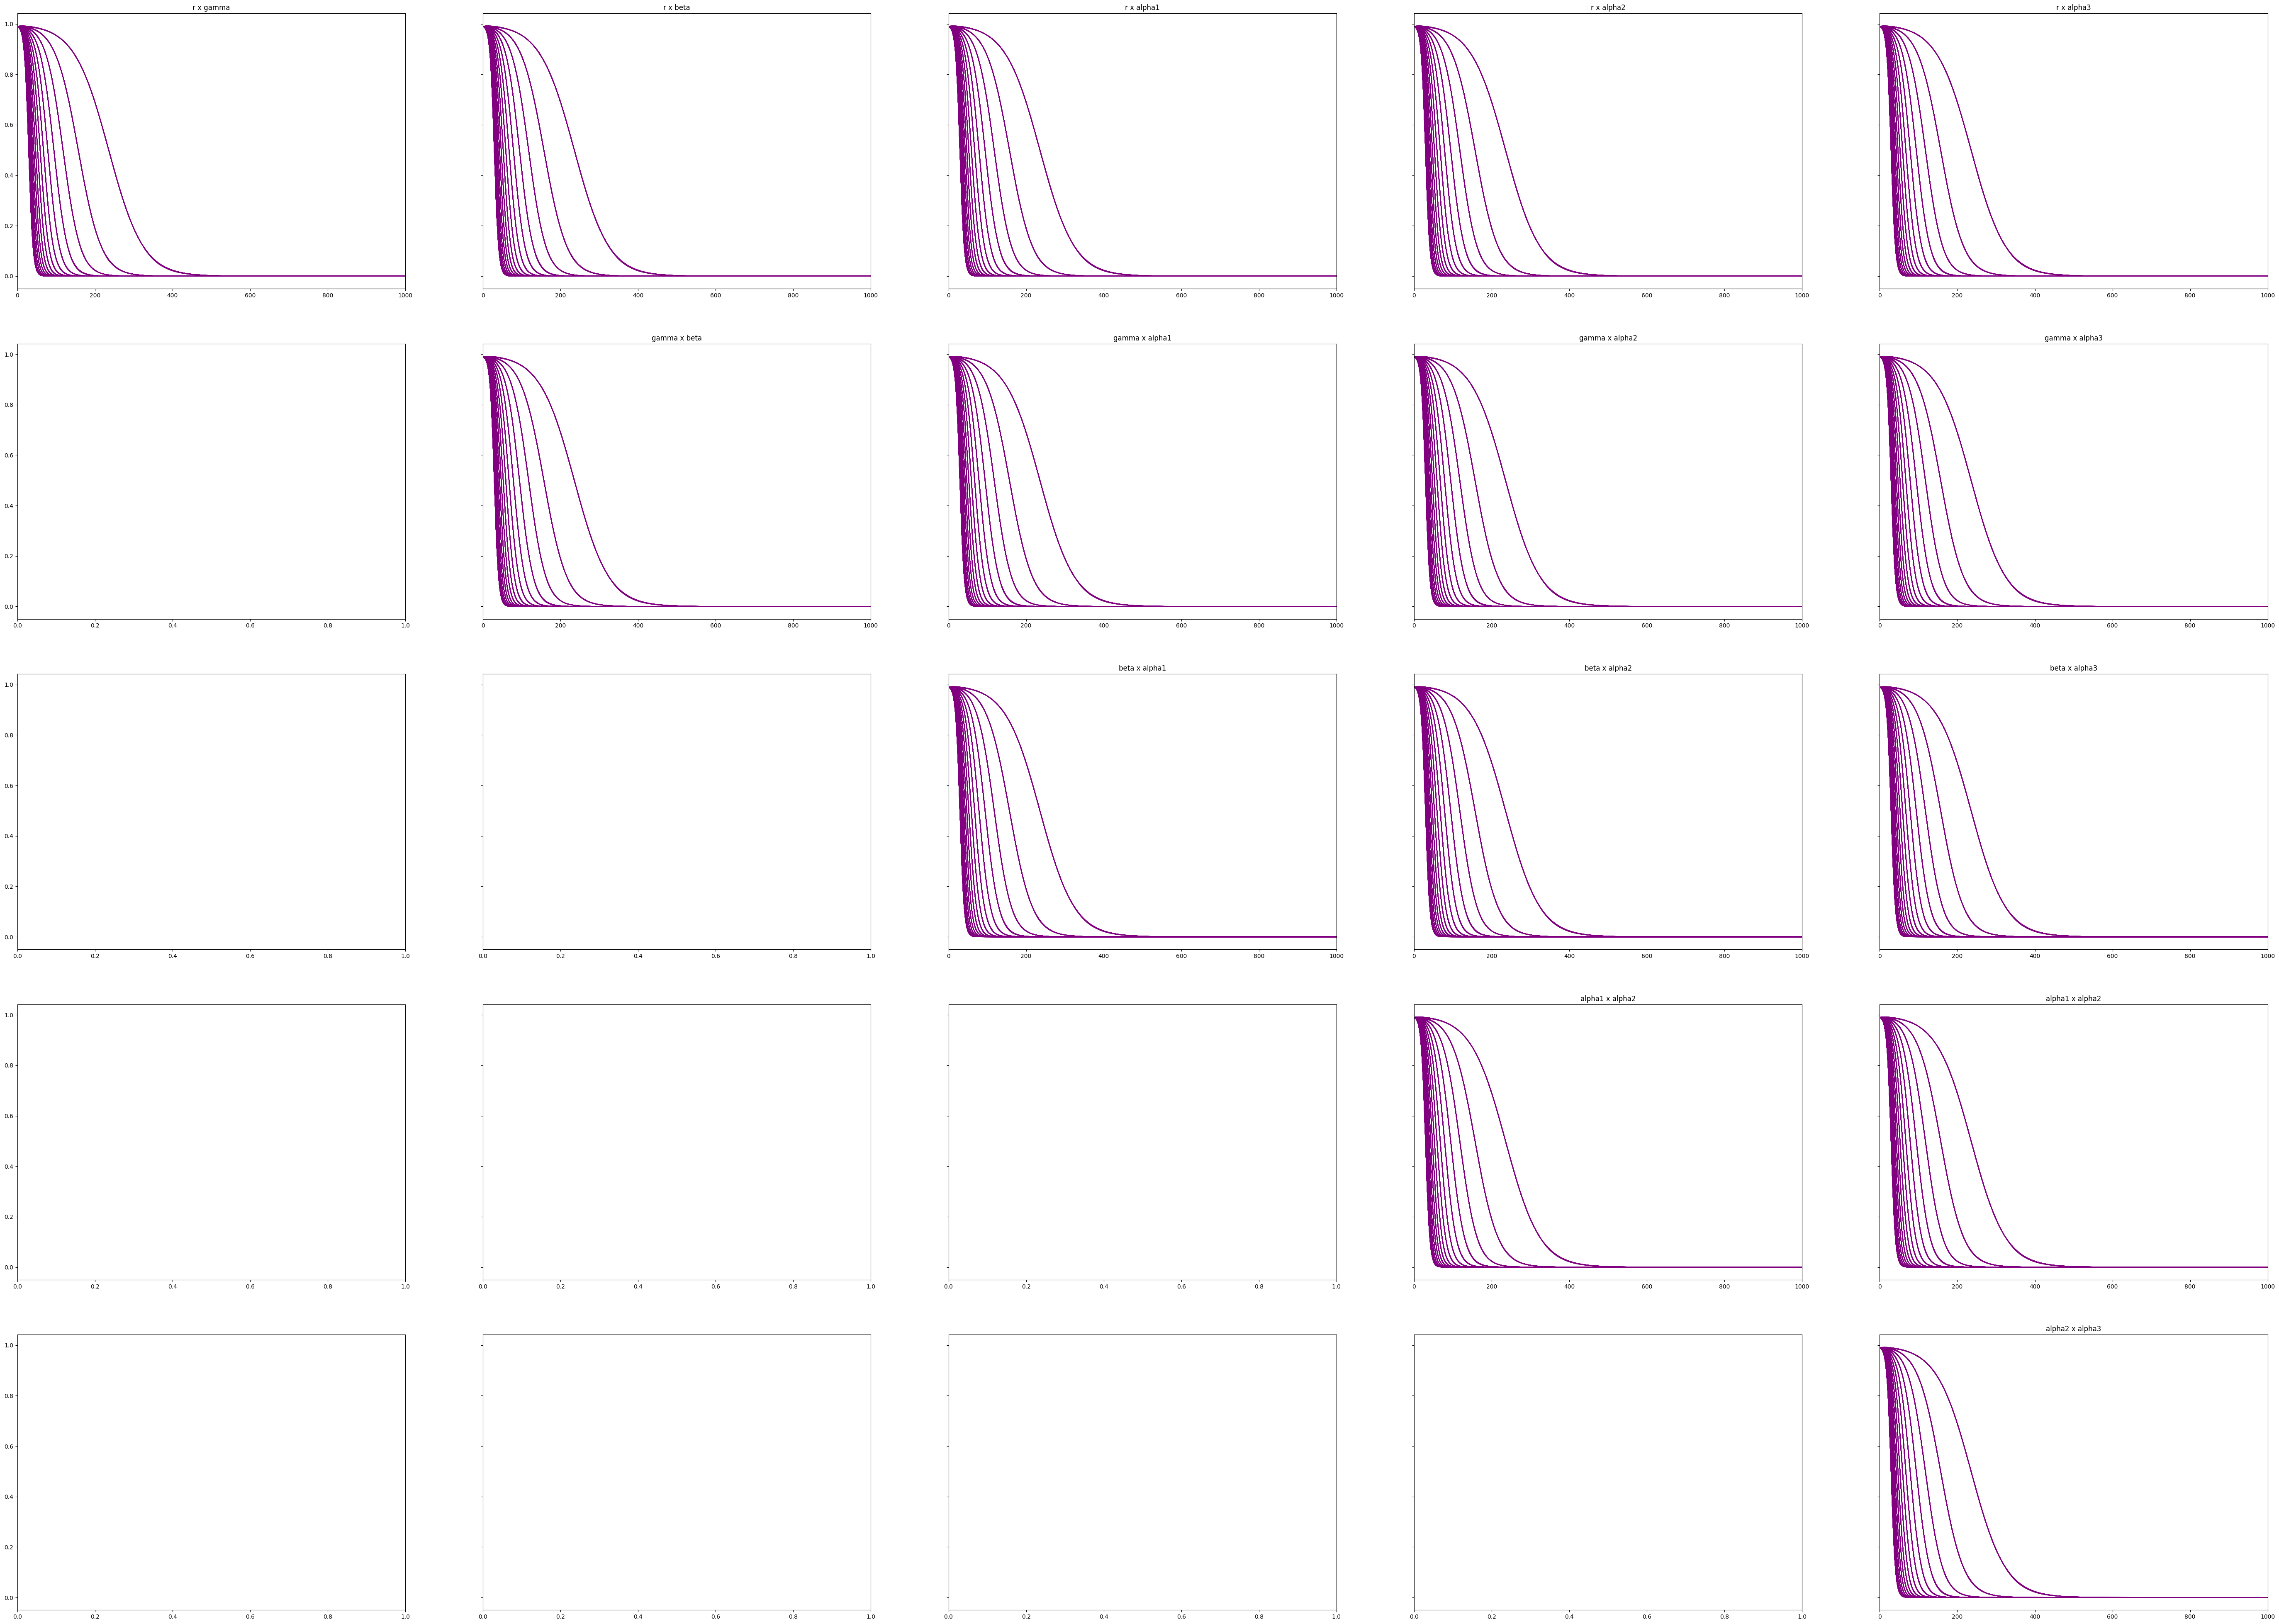

In [372]:
figure, ax = plt.subplots(ncols=5, nrows = 5, sharey=True, figsize=(70, 50))

# r x all ---------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#r x gamma ---------------------------------------------------------------------------------
outputs_r_gamma = parcross_r_gamma(r_value, gamma_value)
plottime(outputs_r_gamma)

for i in C_val:
        ax[0,0].plot(C_array[i], c = 'purple')

ax[0,0].set_xlim(0,1000)
ax[0,0].set_title('r x gamma')

#r x beta ---------------------------------------------------------------------------------
outputs_r_beta = parcross_r_beta(r_value, beta_value)
plottime(outputs_r_beta)

for i in C_val:
        ax[0,1].plot(C_array[i], c = 'purple')

ax[0,1].set_xlim(0,1000)
ax[0,1].set_title('r x beta');

#r x alpha1 ---------------------------------------------------------------------------------
outputs_r_a1 = parcross_r_a1(r_value, alpha1_value)
plottime(outputs_r_a1)

for i in C_val:
        ax[0,2].plot(C_array[i], c = 'purple')

ax[0,2].set_xlim(0,1000)
ax[0,2].set_title('r x alpha1');

#r x alpha2 ---------------------------------------------------------------------------------
outputs_r_a2 = parcross_r_a2(r_value, alpha2_value)
plottime(outputs_r_a2)

for i in C_val:
        ax[0,3].plot(C_array[i], c = 'purple')

ax[0,3].set_xlim(0,1000)
ax[0,3].set_title('r x alpha2');

#r x alpha3 ---------------------------------------------------------------------------------
outputs_r_a3 = parcross_r_a3(r_value, alpha3_value)
plottime(outputs_r_a3)

for i in C_val:
        ax[0,4].plot(C_array[i], c = 'purple')

ax[0,4].set_xlim(0,1000)
ax[0,4].set_title('r x alpha3');


# gamma x all ---------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#gamma x beta ---------------------------------------------------------------------------------
outputs_gamma_beta = parcross_gamma_beta(gamma_value, beta_value)
plottime(outputs_gamma_beta)

for i in C_val:
        ax[1,1].plot(C_array[i], c = 'purple')

ax[1,1].set_xlim(0,1000)
ax[1,1].set_title('gamma x beta');

#gamma x alpha1 ---------------------------------------------------------------------------------
outputs_gamma_a1 = parcross_gamma_a1(gamma_value, alpha1_value)
plottime(outputs_gamma_a1)

for i in C_val:
        ax[1,2].plot(C_array[i], c = 'purple')

ax[1,2].set_xlim(0,1000)
ax[1,2].set_title('gamma x alpha1');

#gamma x alpha2 ---------------------------------------------------------------------------------
outputs_gamma_a2 = parcross_gamma_a2(gamma_value, alpha2_value)
plottime(outputs_gamma_a2)

for i in C_val:
        ax[1,3].plot(C_array[i], c = 'purple')

ax[1,3].set_xlim(0,1000)
ax[1,3].set_title('gamma x alpha2');

#gamma x alpha3 ---------------------------------------------------------------------------------
outputs_gamma_a3 = parcross_gamma_a3(gamma_value, alpha3_value)
plottime(outputs_gamma_a3)

for i in C_val:
        ax[1,4].plot(C_array[i], c = 'purple')

ax[1,4].set_xlim(0,1000)
ax[1,4].set_title('gamma x alpha3');

# beta x all ---------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#beta x alpha1 ---------------------------------------------------------------------------------
outputs_beta_a1 = parcross_beta_a1(beta_value, alpha1_value)
plottime(outputs_beta_a1)

for i in C_val:
        ax[2,2].plot(C_array[i], c = 'purple')

ax[2,2].set_xlim(0,1000)
ax[2,2].set_title('beta x alpha1');

#beta x alpha2 ---------------------------------------------------------------------------------
outputs_beta_a2 = parcross_beta_a2(beta_value, alpha2_value)
plottime(outputs_beta_a2)

for i in C_val:
        ax[2,3].plot(C_array[i], c = 'purple')

ax[2,3].set_xlim(0,1000)
ax[2,3].set_title('beta x alpha2');

#beta x alpha3 ---------------------------------------------------------------------------------
outputs_beta_a3 = parcross_beta_a3(beta_value, alpha3_value)
plottime(outputs_beta_a3)

for i in C_val:
        ax[2,4].plot(C_array[i], c = 'purple')

ax[2,4].set_xlim(0,1000)
ax[2,4].set_title('beta x alpha3');


# alpha1 x all ---------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#alpha1 x alpha2 ---------------------------------------------------------------------------------
outputs_a1_a2 = parcross_a1_a2(alpha1_value, alpha2_value)
plottime(outputs_a1_a2)

for i in C_val:
        ax[3,3].plot(C_array[i], c = 'purple')

ax[3,3].set_xlim(0,1000)
ax[3,3].set_title('alpha1 x alpha2');

#alpha1 x alpha3 ---------------------------------------------------------------------------------
outputs_a1_a3 = parcross_a1_a3(alpha1_value, alpha3_value)
plottime(outputs_a1_a3)

for i in C_val:
        ax[3,4].plot(C_array[i], c = 'purple')

ax[3,4].set_xlim(0,1000)
ax[3,4].set_title('alpha1 x alpha2');

# alpha2 x alpha3 ---------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#alpha2 x alpha3 ---------------------------------------------------------------------------------
outputs_a2_a3 = parcross_a2_a3(alpha2_value, alpha3_value)
plottime(outputs_a2_a3)

for i in C_val:
        ax[4,4].plot(C_array[i], c = 'purple')

ax[4,4].set_xlim(0,1000)
ax[4,4].set_title('alpha2 x alpha3');

figure.savefig('parameter cross-analyses_no herbivores_net coral and macro growth_RK45 Solver_p2=55') 

## Heatmaps (for each, change function title, value string, & plot labels/title)

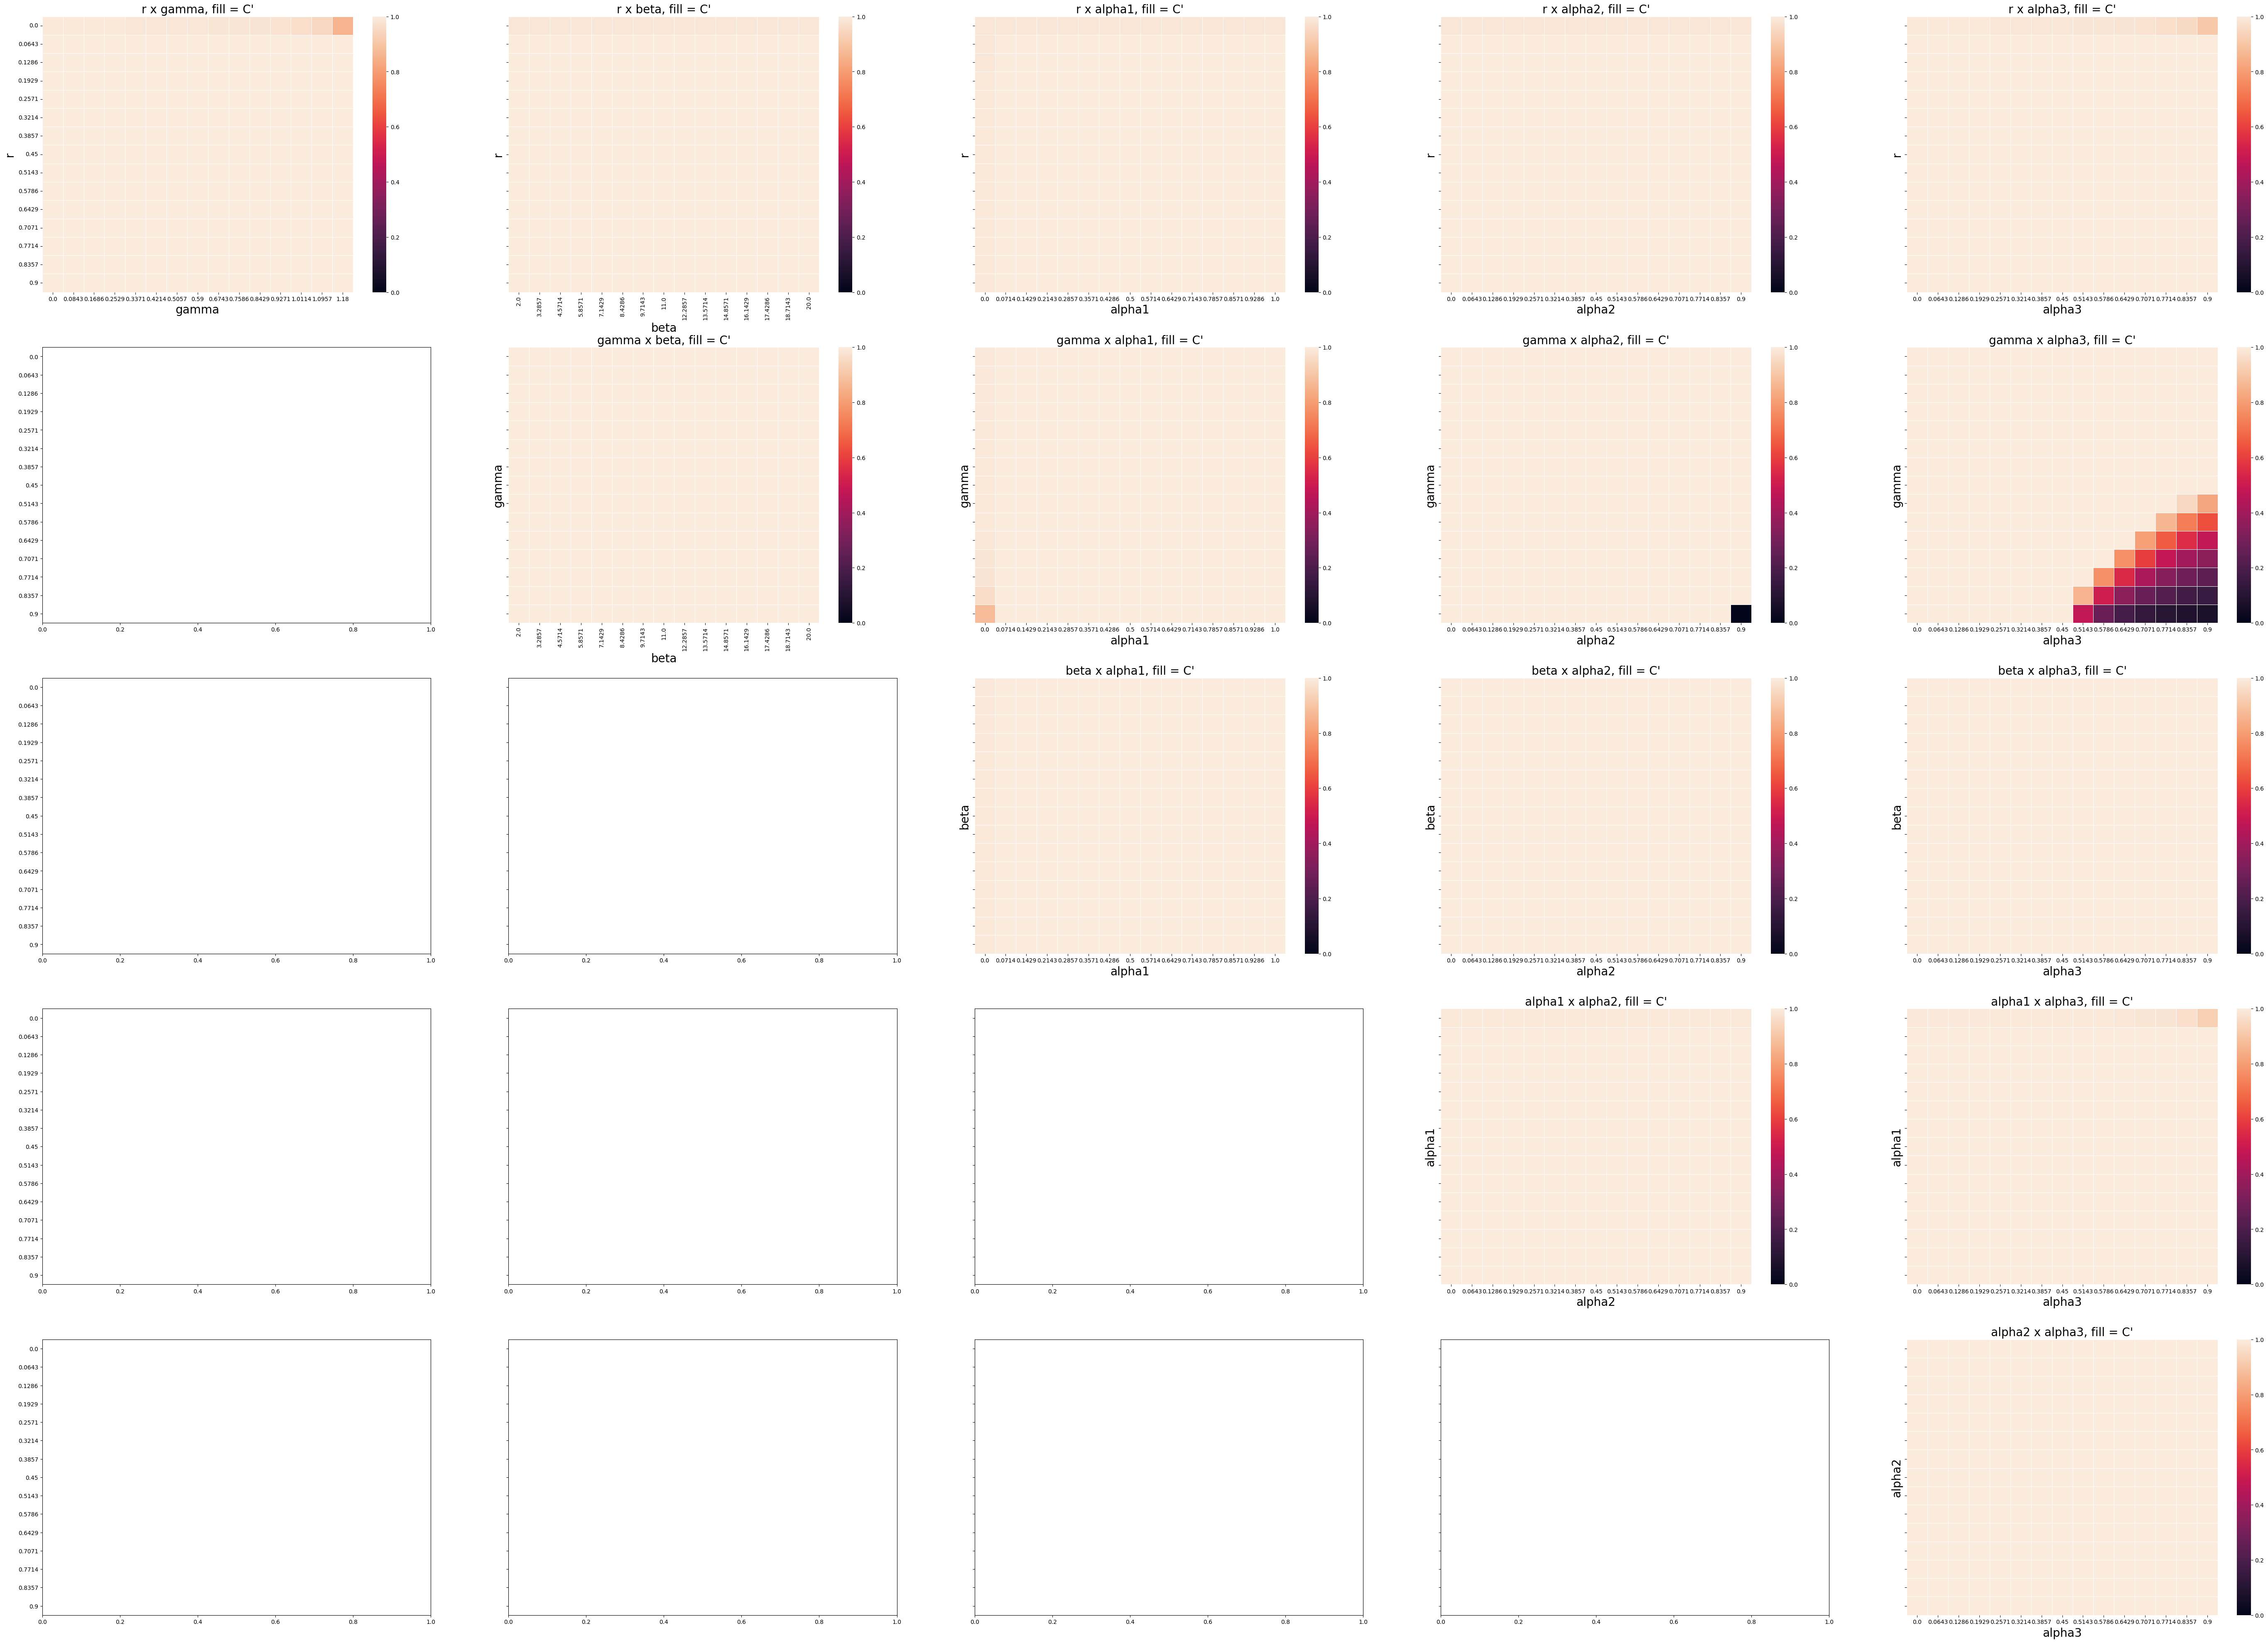

In [373]:
figure, ax = plt.subplots(ncols=5, nrows = 5, sharey=True, figsize=(70, 50))

# r x all ---------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------

df = outputs_r_gamma[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[0,0])
ax[0,0].set_xlabel('gamma', fontsize = 20)
ax[0,0].set_ylabel('r', fontsize = 20)
ax[0,0].set_title("r x gamma, fill = C'", fontsize = 20);

df = outputs_r_beta[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[0,1])
ax[0,1].set_xlabel('beta', fontsize = 20)
ax[0,1].set_ylabel('r', fontsize = 20)
ax[0,1].set_title("r x beta, fill = C'", fontsize = 20);

df = outputs_r_a1[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[0,2])
ax[0,2].set_xlabel('alpha1', fontsize = 20)
ax[0,2].set_ylabel('r', fontsize = 20)
ax[0,2].set_title("r x alpha1, fill = C'", fontsize = 20);

df = outputs_r_a2[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[0,3])
ax[0,3].set_xlabel('alpha2', fontsize = 20)
ax[0,3].set_ylabel('r', fontsize = 20)
ax[0,3].set_title("r x alpha2, fill = C'", fontsize = 20);

df = outputs_r_a3[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[0,4])
ax[0,4].set_xlabel('alpha3', fontsize = 20)
ax[0,4].set_ylabel('r', fontsize = 20)
ax[0,4].set_title("r x alpha3, fill = C'", fontsize = 20);

# gamma x all ---------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------

df = outputs_gamma_beta[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[1,1])
ax[1,1].set_xlabel('beta', fontsize = 20)
ax[1,1].set_ylabel('gamma', fontsize = 20)
ax[1,1].set_title("gamma x beta, fill = C'", fontsize = 20);

df = outputs_gamma_a1[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[1,2])
ax[1,2].set_xlabel('alpha1', fontsize = 20)
ax[1,2].set_ylabel('gamma', fontsize = 20)
ax[1,2].set_title("gamma x alpha1, fill = C'", fontsize = 20);

df = outputs_gamma_a2[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[1,3])
ax[1,3].set_xlabel('alpha2', fontsize = 20)
ax[1,3].set_ylabel('gamma', fontsize = 20)
ax[1,3].set_title("gamma x alpha2, fill = C'", fontsize = 20);

df = outputs_gamma_a3[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[1,4])
ax[1,4].set_xlabel('alpha3', fontsize = 20)
ax[1,4].set_ylabel('gamma', fontsize = 20)
ax[1,4].set_title("gamma x alpha3, fill = C'", fontsize = 20);

# beta x all ---------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------

df = outputs_beta_a1[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[2,2])
ax[2,2].set_xlabel('alpha1', fontsize = 20)
ax[2,2].set_ylabel('beta', fontsize = 20)
ax[2,2].set_title("beta x alpha1, fill = C'", fontsize = 20);

df = outputs_beta_a2[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[2,3])
ax[2,3].set_xlabel('alpha2', fontsize = 20)
ax[2,3].set_ylabel('beta', fontsize = 20)
ax[2,3].set_title("beta x alpha2, fill = C'", fontsize = 20);

df = outputs_beta_a3[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[2,4])
ax[2,4].set_xlabel('alpha3', fontsize = 20)
ax[2,4].set_ylabel('beta', fontsize = 20)
ax[2,4].set_title("beta x alpha3, fill = C'", fontsize = 20);

# alpha1 x all ---------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------

df = outputs_a1_a2[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[3,3])
ax[3,3].set_xlabel('alpha2', fontsize = 20)
ax[3,3].set_ylabel('alpha1', fontsize = 20)
ax[3,3].set_title("alpha1 x alpha2, fill = C'", fontsize = 20);

df = outputs_a1_a3[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[3,4])
ax[3,4].set_xlabel('alpha3', fontsize = 20)
ax[3,4].set_ylabel('alpha1', fontsize = 20)
ax[3,4].set_title("alpha1 x alpha3, fill = C'", fontsize = 20);

# alpha2 x alpha3 ---------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------

df = outputs_a2_a3[1]
heatmap = (df.pivot(index = "p1", columns = "p2", values = "C_prime"))
sns.heatmap(heatmap, vmin=0, vmax=1, annot=False, linewidths=.5, ax=ax[4,4])
ax[4,4].set_xlabel('alpha3', fontsize = 20)
ax[4,4].set_ylabel('alpha2', fontsize = 20)
ax[4,4].set_title("alpha2 x alpha3, fill = C'", fontsize = 20);

figure.savefig('parameter cross-analyses_no herbivores_net coral and macro growth_RK45 Solver_p2=55') 

## Code for finding ranges of parameters where coral can exist 
(kept just in case it becomes useful)

In [374]:
#df_r_alpha3 = pd.DataFrame(r_alpha3_outputs_prime, columns=['r','alpha3','C_prime','M_prime','T_prime'])
#threshold_r_alpha3 = df_r_alpha3[df_r_alpha3['C_prime'] > 0.01]

#df_gamma_alpha3 = pd.DataFrame(gamma_alpha3_outputs_prime, columns=['gamma','alpha3','C_prime','M_prime','T_prime'])
#threshold_gamma_alpha3 = df_gamma_alpha3[df_gamma_alpha3['C_prime'] > 0.01]

#df_beta_alpha3 = pd.DataFrame(beta_alpha3_outputs_prime, columns=['beta','alpha3','C_prime','M_prime','T_prime'])
#threshold_beta_alpha3 = df_beta_alpha3[df_beta_alpha3['C_prime'] > 0.01]

#df_alpha1_alpha3 = pd.DataFrame(alpha1_alpha3_outputs_prime, columns=['alpha1','alpha3','C_prime','M_prime','T_prime'])
#threshold_alpha1_alpha3 = df_alpha1_alpha3[df_alpha1_alpha3['C_prime'] > 0.01]

#df_alpha3_alpha2 = pd.DataFrame(alpha3_alpha2_outputs_prime, columns=['alpha3','alpha2','C_prime','M_prime','T_prime'])
#threshold_alpha3_alpha2 = df_alpha3_alpha2[df_alpha3_alpha2['C_prime'] > 0.01]

In [375]:
#threshold_r_alpha3['alpha3'].max()

#threshold_beta_alpha3['alpha3'].max()

#threshold_alpha1_alpha3['alpha3'].max()

#threshold_alpha3_alpha2['alpha3'].max()

#threshold_gamma_alpha3['alpha3'].max()
#threshold_gamma_alpha3[threshold_gamma_alpha3['alpha3'] > 0]